In [1]:
# automaticlly updates imported methods when they change
%load_ext autoreload
%autoreload 2

import sys
from pathlib import Path
sys.path.append(str(Path().cwd().parent))

# Flir Tau2 Calibration Process

In [2]:
# Packages and data imports:
import seaborn as sns
import pandas as pd
from tools import calc_rx_power, get_meas, prefilt_cam_meas, FilterWavelength, FilterWavelength
from plots import showFacetImages
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from multiprocessing import Pool, cpu_count
from scipy.optimize import nnls
from itertools import product
from tqdm import tqdm
from pathlib import Path
matplotlib.rcParams.update({'font.size': 14})

path_to_files = Path.cwd()
while not (path_to_files / "rawData").is_dir():
    path_to_files = path_to_files.parent
path_to_files = path_to_files / "rawData" / 'calib'

meas_panchromatic, list_power_panchromatic, list_blackbody_temperatures = \
    get_meas(path_to_files, filter_wavelength=FilterWavelength.PAN)


Load measurements: 100%|████████████████████████| 21/21 [00:02<00:00,  8.65it/s]


In [ ]:
# remove the first N_PIX_TO_REMOVE from each meas because of acquisition errors
N_PIX_TO_REMOVE = 0
if N_PIX_TO_REMOVE:
    meas_panchromatic = meas_panchromatic[:, N_PIX_TO_REMOVE:, ...]

## Raw Data Visualization:
Before diving into processing the input images, it's a good idea to have a look at the raw data in order to get a better idea of its quality and evident issues.


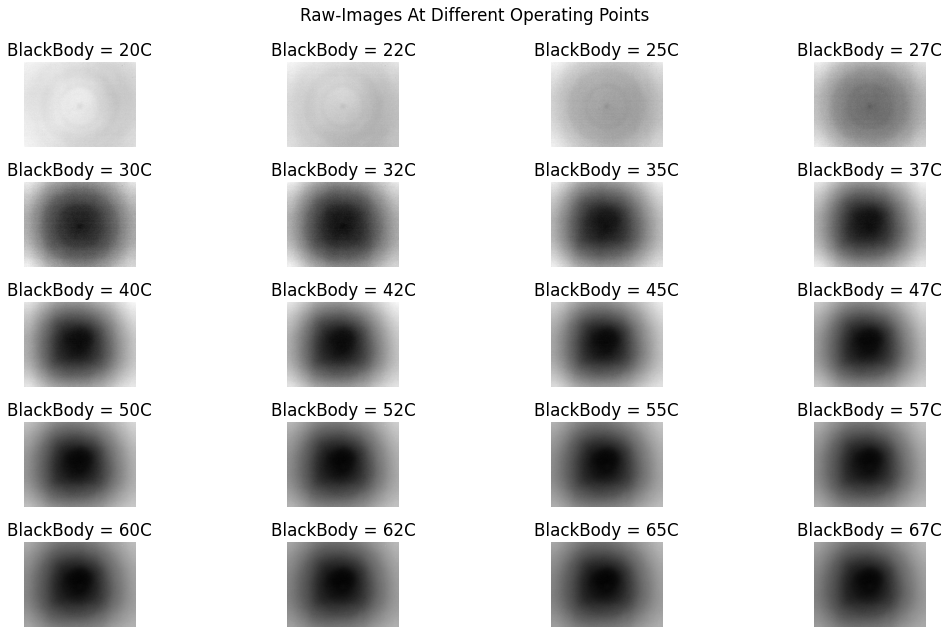

In [3]:
# Display the Average Frames of the different operating points:
ROW_LENGTH = 4
meas_panchromatic_mean = meas_panchromatic.mean(axis=1)
fig, axs = plt.subplots(max(1, meas_panchromatic_mean.shape[0] // ROW_LENGTH), ROW_LENGTH, figsize=(16, 9))
for ax, image, t_bb in zip(axs.ravel(), meas_panchromatic_mean, list_blackbody_temperatures):
    ax.imshow(image, cmap="gray")
    ax.set_title(f"BlackBody = {t_bb}C")
    ax.axis("off")
fig.suptitle("Raw-Images At Different Operating Points")
plt.tight_layout()
plt.show()
plt.close()


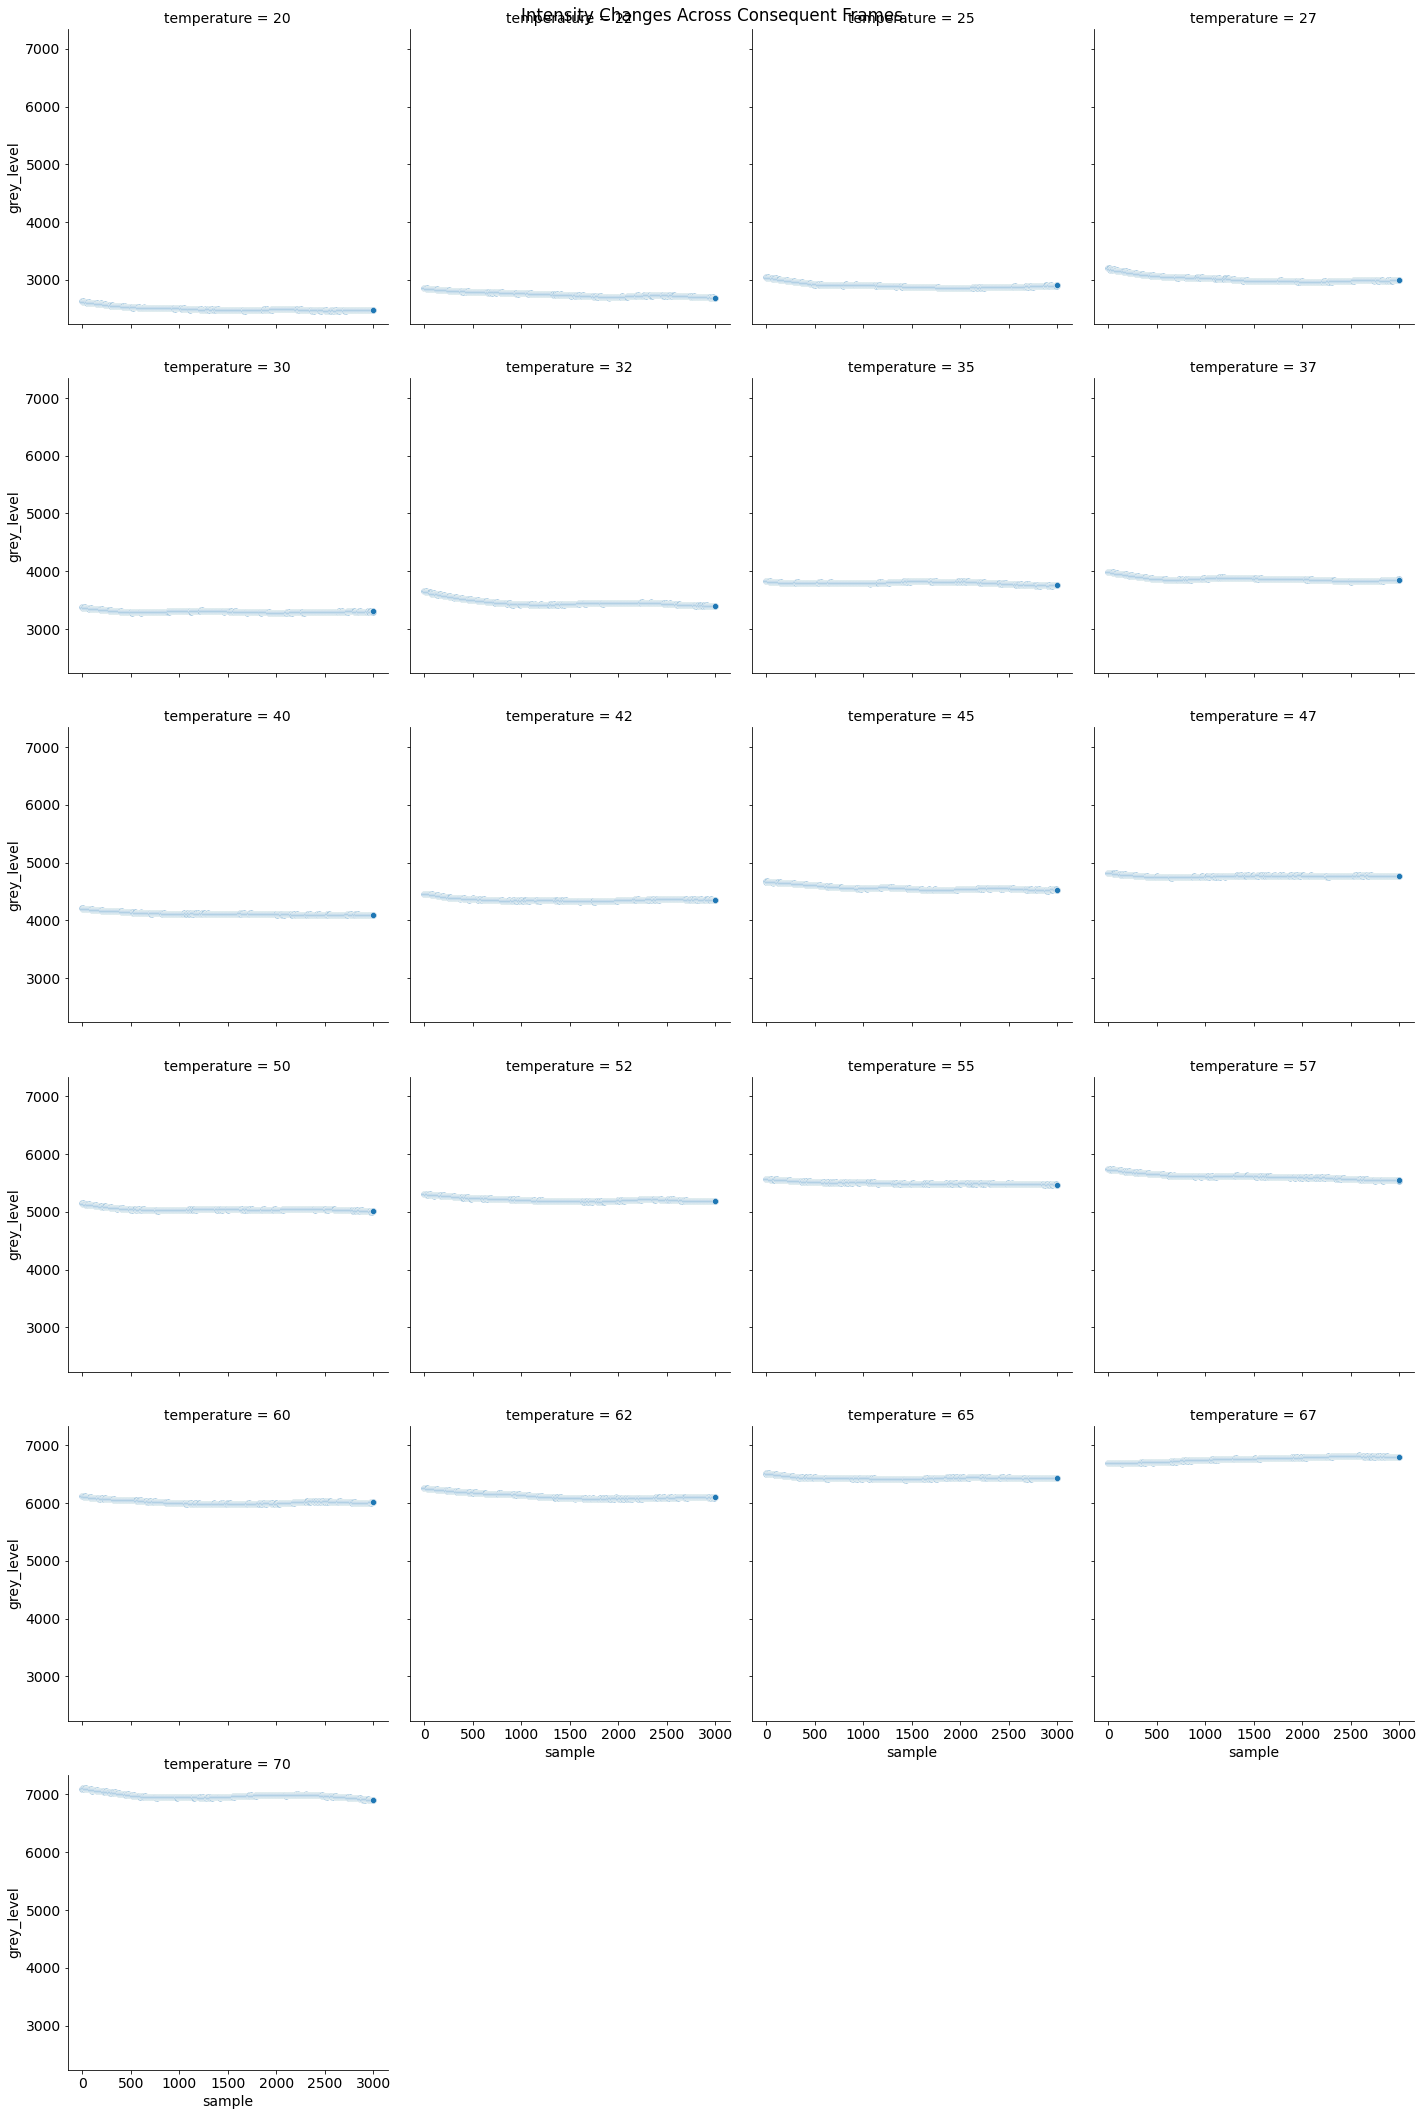

In [4]:
# Plot the change in intensity (grey-level) of a random pixel for a continuous frames acquisition:
def plotNoiseAnalysis(data):
    pix_over_frames_disp = data.melt(
        var_name="temperature", value_name="grey_level", ignore_index=False)
    pix_over_frames_disp.index.rename("sample", inplace=True)
    pix_over_frames_disp.reset_index(level=0, inplace=True)
    sns.relplot(x="sample", y="grey_level", data=pix_over_frames_disp,
                col="temperature", col_wrap=4)


pix_idx = np.random.randint(low=[0, 0], high=meas_panchromatic.shape[2:], size=2)
pix_over_frames = pd.DataFrame(meas_panchromatic[..., pix_idx[0], pix_idx[1]].T, 
                               columns=list_blackbody_temperatures)
plotNoiseAnalysis(pix_over_frames)
fig = plt.gcf()
fig.suptitle("Intensity Changes Across Consequent Frames")
fig.tight_layout()

## Pre-Processing
Evident from the raw-data visualizations, there are 3 issues that come up:
1. The first frame of each temperature appears to be an outlier. infact, after some more careful verification, it seems that in some cases, all first 3 frames exhibit this phenomenon. To be on the safe side, it would be a good idea to discard them for the purpose of any further analysis.
2. The noise is highly correlated, as the trends in noise are smooth. This means that a gaussian noise assumption isn't valid. Nontheless, as trends are inconsistent at different temperatures (some are positive, some negative, and some oscillate and return to the same level) and since the trends' magnitudes aren't very significant, averaging frames might still be the best idea to eliminate the noise.
3. While not easily observable, some pixels in the upper-right corner are "burned", resulting in a salt-and-pepper like noise.

To tackle some of the issues, a pre-processing function was engineered, which chomps the 3 first frames, and filters the remaining frames with a 2x2 median filter.

In [ ]:
from tools import prefilt_cam_meas, showFacetImages
meas_panchromatic_clean = prefilt_cam_meas(meas_panchromatic)
img_comp = np.stack((meas_panchromatic[0].mean(
    axis=0), meas_panchromatic_clean[0].mean(axis=0)))
showFacetImages(img_comp, "Phase", [
                "Before Pre-Processing", "After Pre-Processing"], facet_col_wrap=2,
                title="An Examplary Operating-Point Before and After Applying Pre-Processing")


___

## Calibration
The target of the calibration process is to be able to predict how a filtered scene will look, in terms of grey-levels, given its pan-chromatic version as input.

This calibration will enable us to utilize a physical prior about the expected filtered scene to be encorporated as part of the loss of the colorization model.

### LWIR Filters Artifacts
When capturing real-world scenes using TAU2, an unexpected and unclear spherical distortion appears when applying an IR filter.
This artifact only appears when applying a filter, as can be seen from the following example:

In [ ]:
from tqdm import tqdm
from itertools import product
from scipy.optimize import nnls
from multiprocessing import Pool, cpu_count
from tools import calc_rx_power, get_meas, prefilt_cam_meas, SpectralFilter
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2


data_base_dir = Path(
    r"C:\Users\omriber\Documents\Thesis\MultiSpectralCtrl\download")

data_fname = "cnt1_20210830_h15m53s38.npy"
data = np.load(Path(data_base_dir, data_fname))

fig = make_subplots(1, 2)
fig = px.imshow(data[0, 0], color_continuous_scale='gray',
                title="Pan-Chromatic")

fig.show()
fig = px.imshow(data[1, 0], color_continuous_scale='gray', title="Filter1")
fig.show()


While seemingly similar to vignetting, it's clearly not, as in opposed to vignetting, the center is brighter than the edges (in vignetting its vice-versa).

Moreover, many pixels have a higher intensity level when the filter is applied, in contrast to the expected physical phenomenon, by which the grey level is proportional to the radiated power. This can be clearly observed when using the same dynamic range for showing both images:

In [ ]:
fig = px.imshow(data[:2, 0, ...], facet_col=0,
                color_continuous_scale='gray')
fig.layout.annotations[0].text="Pan-Chromatic"
fig.layout.annotations[1].text="Filtered"
fig.show()


This unexpected bias difference in favor of the filtered version might be due to the filter acting as a black-body, radiating towards the bolumetric sensor due to it's temperature and relatively high proximity to the sensor.

While unexpected, this is not necessarily an issue, as we don't necessarily intend to cancel it out, but rather characterize it in order to be able to predict it and use it to simulate the filtered scene given the pan-chromatic one.

### Physical Model
To tackle the observed issue, we must first assume some model the generated distortion in the grey-levels.
I propose the following linear model:
$$ GL^{(f)}_{i,j} = \alpha_{i,j}P_{i,j}^{(f)}(T) + \beta^{(f)} + n_{i,j}$$
Where:
* $GL^{(f)}_{i,j}$ are the grey level of the i,j'th pixel (per filter).
* $P_{i,j}^{(f)}(T)$ is the radiance power of the i,j'th pixel (per filter), which can be calculated analytically based on Plank's law.
* $\alpha_{i,j}$ are the per-pixel slopes of the liner model. The core assumption of the model is that these coefficients are filter-invarient, hence can be learned using the unfiltered (panchromatic) setup, and used in the filtered setups to recover the other parameters of interest.
* $\beta_{i,j}^{(f)}$ is the linear model bias (perhaps not pixel-dependent). For the filtered setups, we assume that this factor is mostly due to the radiance of the filter itself towards the sensor.
* $n_{i,j}$ is the per-pixel additive noise.

### Calibration Workflow:
To obtain a full calibration that will enable us to predict a filtered scene given its panchromatic conterpart, we need to:
1. Estimate the temperature given grey-level, using the pan-chromatic channel.
2. Estimate $\alpha_{i,j}$ and $\beta_{i,j}^{(f)}$.


### 1. Temperature Calibration
One of the desired outputs of our calibration process is being able to estimate the temperature based on the pan-chromatic grey-levels. To that end, we assume a linear model between temperature and grey-level, and perform a linear regression.
$$GL = \hat{\text{intercept}} \times T +\hat{\text{slope}}$$
First, we can inspect the estimated regression parameters of an arbitrary pixel:


In [ ]:
# first, let's display a regression model for an arbitrary pixel:
from sklearn.linear_model import LinearRegression
from IPython.display import display, Latex

i, j = np.random.randint((0, 0), meas_panchromatic_clean.shape[2:])
regress_target_eg = meas_panchromatic_clean[..., i, j].flatten()
x, y = np.array(list_blackbody_temperatures).repeat(
    meas_panchromatic_clean.shape[1])[:, np.newaxis], regress_target_eg[:, np.newaxis]
lr = LinearRegression().fit(x, y)
plt.figure(figsize=(16, 9))
res = sns.regplot(x=x, y=y, fit_reg=True)
plt.title(f"Regression model for random pixel {(i, j)}")
plt.xlabel("Temperature[C]")
plt.ylabel("Grey-Level")
plt.grid()

display(Latex(
    fr"Regression result: $GL = {lr.coef_.squeeze():.3f} \times T +{lr.intercept_.squeeze():.3f}$"))
display(Latex(fr"$R^2 = {lr.score(x, y):.3f}$"))



Now, we move forward to calculating and visualizing the estimated parameters for all image pixels:

In [ ]:
from tqdm import tqdm
import plotly.express as px
# Compute the regression (pixel-wise, in a loop, to avoid memory congestion):
meas_shape = meas_panchromatic_clean.shape
lr = LinearRegression()
lr_res = {"slopes": np.zeros(
    meas_shape[2:]), "intercepts": np.zeros(meas_shape[2:])}
lr_all = np.zeros(meas_shape[2:])
for i in tqdm(range(meas_shape[2])):
    for j in range(meas_shape[3]):
        lr_ij = lr.fit(x, meas_panchromatic_clean[..., i, j].flatten())
        lr_res["slopes"][i, j] = lr_ij.coef_
        lr_res["intercepts"][i, j] = lr_ij.intercept_

# plot slopes:
fig = px.imshow(lr_res["slopes"], color_continuous_scale='gray',
                title="Linear Regression Slopes Map")
fig.show()

fig = px.imshow(lr_res["intercepts"], color_continuous_scale='gray',
                title="Linear Regression Intercepts Map")
fig.show()


Now, we move forward to estimating the temperature, based on the acquired grey-levels (the inverse-regression)
$$ \hat{GL} = slope \times T + \text{intercept} \Rightarrow \hat{T} = \frac{GL - \text{intercept}}{\text{slope}} $$

First, I present the estimation of the best-fit operating point (45C), and later a barplot summarizing the average temperature estimation error for all operating points:

In [ ]:
def gl2T(gl, slope, intercept): return (gl-intercept) / slope

# Estimate for the best OP:
operating_point = 45  # [C]
op_image = meas_panchromatic_clean.mean(
    axis=1)[list_blackbody_temperatures.index(operating_point), ...]
t_hat = gl2T(op_image, lr_res["slopes"], lr_res["intercepts"])

fig = px.imshow(t_hat, color_continuous_scale='gray',
                title=f"Temperature Estimation (GT={operating_point}[C])")
fig.show()


# Averatge Estimation Error for all OPs:
meas_panchromatic_df = pd.DataFrame(
    meas_panchromatic_clean.mean(axis=1).reshape(meas_shape[0], -1).T, columns=list_blackbody_temperatures)
t_hat_df = gl2T(meas_panchromatic_df,
                lr_res["slopes"].reshape(-1, 1), lr_res["intercepts"].reshape(-1, 1))
est_err = np.array(list_blackbody_temperatures) - t_hat_df

fig, ax = plt.subplots(figsize=(16, 9))
np.sqrt((est_err**2).mean()).plot.bar(ax=ax)
ax.set_xlabel("Operating Point[C]")
ax.set_ylabel("Estimation Error[C]")
ax.set_title("Estimated Temperature RMSE")
ax.grid(axis="y")
print("Estimation Statistics:\n")
t_hat_df.describe()


A few observations can be made based on the obtained statistics:
1. The linear model isn't a very good estimate for many operating points, with an RMSE of > 2C in the worst case, and >1C for more than half the operating points.
2. The standard-deviation of all operating points is incredibely small, suggesting that the error trend is very similar for all pixels

These observations give hope that a better model(perhaps a higher degree polynomial) will result in a better fit for all pixels.

Regardless of the suggested models, a proper evaluation should be based on a validation set of measurements that weren't used for constructing the model.


#### SNR
One of the questions that arises is how good the signal-to-noise ratio of the acquired data is.

To answer it, we can estimate the noise level (std) of each operating point, and compare it to the regression model's parameters:

In [ ]:
## calculate the per-pixel std map
std_map = meas_panchromatic_clean.std(axis=1)
showFacetImages(std_map, "Temperature", list_blackbody_temperatures, title="Noise Standard-Deviation Per Operating Point")

We can see that the worst case scenario std is $\approx 45 [\frac{GL}{C}]$. Hence, and under the assumption that the noise is i.i.d (which isn't accurate, as we can see from the intensity-over-frames graphs that it's highly correlated) - we can reduce it by the square-root of the acquired frames number after averaging. E.g, averaging over 2000 framse is expected to reduce the noise std to $\frac{45}{\sqrt(2000)} \approx 1$ grey-levels in the worst case.

As the slopes of the regression model are all  $ >80 [\frac{GL}{C}]$), the signal is a lot greater than the averaged samples noise std ($\approx 1 [\frac{GL}{C}]$), and is even greater than the worst-case single-sample noise ($\approx 45 [\frac{GL}{C}]$).


### 2. $\alpha_{i,j}$ and $\beta_{i,j}^{(f)}$ Calibration



#### Calibration plan:
1. Estimate $\alpha_{i,j}$, the per-pixel scale-factor converting from radiance power to grey-level:
    1. Capture an unfiltered image (pan-chromatic) of the black-body in several temperature set-points, to obtain a grey level per-pixel $GL^{\text{pan}}_{i,j}$
    2. Analytically calculate the expected radiance power by integrating over Plank's spectral radiance density $B(\lambda, T)$:
        $$P^{\text{pan}}(\lambda^{\text{pan}}_{0,1}, T) = \int_{\lambda^{\text{pan}}_0}^{\lambda^{\text{pan}}_1} B(\lambda, T) d\lambda$$
        Where $B(\lambda, T) = \frac{2h/c^2\lambda^3}{exp(h/KT\lambda)-1}$ is Plank's spectral radiance density, and $\lambda^{\text{pan}}_{0,1}$ should be determined by TAU's natural band-width (After looking at the camera's SPEC, it seems that $\lambda_0=7.5\mu m, \: \lambda_1=13.5\mu m$).

        Alternatively, and assuming an infinite bandwidth with optimal transmission response, we can use the Stefan–Boltzmann law to assert that $P^{\text{pan}} = \frac{1}{\pi} \sigma T^4 $
    3. Use linear regression ($GL_{i,j}^{\text{pan}}$ vs $\hat{P}^{\text{pan}}$) to estimate the pan-chromatic $\hat{\alpha}_{i,j}^{\text{pan}}$ and $\hat{\beta}^{\text{pan}}$.
    4. Estimate $\alpha_{i,j}$ using $\hat{\alpha}_{i,j} = \frac{GL^{\text{pan}}_{i,j}-\hat{\beta}^{\text{pan}}}{P^{\text{pan}}}$
    <!-- 5. Repeat for every temperature set-point to obtain a (linear) regression model for $\hat{\alpha}_{i,j}(T) = a_0T + b_0$ -->
2. Estimate $\delta^{(f)}_{i,j}$, the per-pixel, per-filter distortion correction coefficients. For each filter (f):
    1. Capture a filtered image of the black-body in several temperature set-points, to obtain a grey level per-pixel $GL^{(f)}_{i,j}$
    2. Analytically calculate the expected radiance power by integrating over Plank's spectral radiance density $B(\lambda, T)$:
        $$P^{(f)}(\lambda_{0,1}, T) = \int_{\lambda_0}^{\lambda_1} B(\lambda, T) f(\lambda) d\lambda$$
        Where now $\lambda_{0,1}$ are determinde by the filter's band-width, and $f(\lambda)$ is the filter's transmitanse response. This time, as a significant portion of the spectrum is cut-off, the Stefan–Boltzmann law can no longer be used to approximate the integral.
    3. Estimate the per-filter bias using the already-estimated $\hat{\alpha}_{i,j}$: $\hat{\beta}^{(f)} = GL^{(f)}_{i,j} - \hat{\alpha}_{i,j}P^{(f)}$. Since we require $\hat{\beta}^{(f)}$ to be constant, the problem is over-constrained, and we could solve for the optimal bias term using optimization (e.g. least-squares).
    4. Use the optimal bias found in (3) to construct a synthetic "expected" grey-level image: $\hat{GL}^{(f)}_{i,j} = \hat{\alpha}_{i,j}P^{(f)} + \hat{\beta}^{(f)}$
    5. In this point, we can compare our expectated image $\hat{GL}^{(f)}_{i,j}$, which is a constant grey-level across all pixels by design, to the actual image $GL^{(f)}_{i,j}$, which suffers from vignetting and possibly other filter-related per-pixel distortions (\delta^{(f)}_{i,j}). The estimation of $\delta^{(f)}_{i,j}$ is still an open issue, and could be of the form of $\hat{\delta}^{(f)}_{i,j} = \frac{\hat{GL^{(f)}_{i,j}}}{GL^{(f)}_{i,j}}$ of maybe $\hat{\delta}^{(f)}_{i,j} = \hat{GL^{(f)}_{i,j}} - GL^{(f)}_{i,j}$ or even a combination of the two (linear model). The answer to that isn't clear, and will maybe become so after exploring the results of previous steps.
    <!-- 5. Repeat for every temperature set-point to obtain a (linear) regression model for $\hat{\beta}^{(f)}_{i,j}(T) = a_1T + b_1$ -->


#### Calculating the Power-Radiance P:
use the API as depicted below:

In [ ]:
from tools import calc_rx_power
import numpy as np
import matplotlib.pyplot as plt
# for pan-chromatic, currently using an ideal, infinitely wide bandwidth filter assumption
rx_power = calc_rx_power(temperature=32, debug=True)


# for a specific filter, provide the central frequency:
lambda_c = 9000 #[nm]
rx_power = calc_rx_power(temperature=32, central_wl=lambda_c, bw=1000, is_ideal_filt=False, debug=True)


To avoid generating the figures each time the calculation is invoked, simply set debug=false (or completely remove it as an argument)

#### Step 0: Model validation
To understand whether our model is right, we first need to see if the relationship between the panchromatic grey-levels $GL^{\text{Pan}}$ and the radiated power $P^{\text{Pan}}$ is indeed linear and with what coefficients

##### Load the panchromatic data:


In [ ]:
temps_to_ommit = [60]
meas_panchromatic, list_power_panchromatic, list_blackbody_temperatures = get_meas(
    path_to_files, ommit_ops=temps_to_ommit)
meas_panchromatic_clean = prefilt_cam_meas(meas_panchromatic)
del meas_panchromatic

##### Plot Grey levels of random pixels Vs power

In [ ]:
import seaborn as sns
from sklearn.linear_model import LinearRegression

meas_panchromatic_clean_mean = meas_panchromatic_clean.mean(axis=1)
i, j = 50, 200
plt.figure(figsize=(16, 9))
sns.regplot(x=list_power_panchromatic, y=meas_panchromatic_clean_mean[:, i, j])
lr = LinearRegression()
reg_res = lr.fit(np.array(list_power_panchromatic)[:, None], meas_panchromatic_clean_mean[:, i, j])
r2 = lr.score(np.array(list_power_panchromatic)[
            :, None], meas_panchromatic_clean_mean[:, i, j])
plt.title(
    f"GL = {reg_res.coef_[0]:.2f}P + {reg_res.intercept_:.2f} ($R^2={r2:.2f}$)")
params = reg_res.get_params()


Seems like the regression model is indeed linear, with a non-negligible bias term.

#### Step 1: estimate $\alpha_{i,j}$

##### Estimate the bias $\hat{\beta}^{\text{pan}}$ (1.3)

In [ ]:
beta_pan = meas_panchromatic_clean.mean(axis=(1, 2, 3))

##### Estimate $\alpha_{i,j}$ (1.4). Non-vectorized implementation is used to avoid RAM abuse.

In [ ]:
alpha = np.empty_like(meas_panchromatic_clean, dtype=float)
for i, op_power in enumerate(list_power_panchromatic):
    alpha[i] = meas_panchromatic_clean[i] - beta_pan[i] / op_power


<!-- ## Get a linear regression model for $\alpha_{i,j}(T)$ -->

In [ ]:
# from sklearn.linear_model import LinearRegression

# meas_shape = meas_panchromatic_clean.shape
# lr = LinearRegression()
# lr_res = {"slopes": np.zeros(
#     meas_shape[2:]), "intercepts": np.zeros(meas_shape[2:])}
# lr_all = np.zeros(meas_shape[2:])

# # ## prepare variables for regression:
# x = np.array(list_power_panchromatic).repeat(meas_panchromatic_clean.shape[1])[:, np.newaxis]
# y = meas_panchromatic_clean.T.reshape(-1, meas_shape[2] * meas_shape[3])


# for i in range(meas_shape[2]):
#     for j in range(meas_shape[3]):
#         lr_ij = lr.fit(x, meas_panchromatic_clean[..., i, j].flatten())
#         lr_res["slopes"][i, j] = lr_ij.coef_
#         lr_res["intercepts"][i, j] = lr_ij.intercept_


# ## Plot results:
# import plotly.express as px

# fig = px.imshow(lr_res["slopes"], color_continuous_scale='gray', title="Linear Regression Slopes Map")
# fig.show()

# fig = px.imshow(lr_res["intercepts"], color_continuous_scale='gray', title="Linear Regression Intercepts Map")
# fig.show()


#### Step 2: estimate $\delta^{(f)}_{i,j}$


##### Calculate the expected radiance power per filter (2.2) and estimate the per-filter bias $\hat{\beta}^{(f)}$ (2.3)

In [ ]:
# import pandas as pd
# # for a specific filter, provide the central frequency:

# # Prepare containers for processed data:
# filters_cw = [filt.value for filt in SpectralFilter if filt.value > 0]
# power_filt = pd.DataFrame(index=list_blackbody_temperatures, columns=filters_cw)
# beta_filt = power_filt.copy()


# # Gather variables required for next block to save redundent calculations:
# meas_shape = meas_panchromatic_clean.shape
# meas_filt_all = np.empty((len(filters_cw), meas_shape[0], *meas_shape[2:]))

# # Process data:
# for i, filter_cw in enumerate(filters_cw):
#     meas_filt, _, _ = get_meas(path_to_files, SpectralFilter(
#         filter_cw), ommit_ops=temps_to_ommit)
#     meas_filt_clean = prefilt_cam_meas(meas_filt)
#     meas_filt_all[i] = meas_filt_clean.mean(axis=1)
#     for temperature in list_blackbody_temperatures:
#         power_filt.loc[temperature, filter_cw] = calc_rx_power(
#             temperature=temperature, central_wl=filter_cw, bw=1000, is_ideal_filt=False)
#         beta_filt.loc[temperature, filter_cw] = meas_filt_clean[i].mean()


#### Load Panchromatic

##### Load Filters

In [ ]:
# dict_measurements = {}

# paths = list(path_to_files.glob('*.npy'))
# for path in tqdm(paths, desc="Load measurements"):
#     temperature_blackbody = int(path.stem.split('_')[-1])
#     try:
#         meas = np.load(str(path))
#     except ValueError:
#         print(f'Cannot load file {str(path)}')
#         continue
#     list_filters = sorted(pd.read_csv(path.with_suffix('.csv')).to_numpy()[:,1])
#     for idx, filter_name in enumerate(list_filters):
#         dict_measurements.setdefault(temperature_blackbody, {}).setdefault(filter_name, meas[idx])
# dict_measurements = {k:dict_measurements[k] for k in sorted(dict_measurements.keys())}
# print(f'Available filtes: {list_filters}nm')
# list_blackbody_temperatures = list(dict_measurements.keys())
# print(f'BlackBody reference temperatures: {list_blackbody_temperatures}C')